In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# importing the models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBRegressor

# addition predifined 'functions' for splitting the data and evaluating the model
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Support functions

In [2]:
class match_support_functions():
        
    def categorical_to_numerical_convert(self,df,cat_columns):

        for column in cat_columns:
            one_hot = pd.get_dummies(df[column])
            # Drop column as it is now encoded
            df = df.drop(column,axis = 1)
            # Join the encoded df
            df = df.join(one_hot)

        return df

    def IQR_outlier_treatment(self,df, datacolumn, V1 , V3):

        Q1,Q3 = np.percentile(df[datacolumn] , [V1,V3])
        IQR = Q3 - Q1
        lower_range = Q1 - (1.5 * IQR)
        upper_range = Q3 + (1.5 * IQR)

        #print(f'{datacolumn} minimum range:',lower_range)
        #print(f'{datacolumn} maximum range:',upper_range) 
        df = df[(df[datacolumn] > lower_range) & (df[datacolumn] < upper_range)]
        
    def get_top_correlation(self,df):
        cor = df.corr().abs()
        cor2 = cor.unstack()
        cor3 = cor2.sort_values(kind="quicksort", ascending = False)

        return pd.DataFrame(cor3)

    def evaluate_prediction(self,y_prediction,y_val):
        
        mse = mean_squared_error(y_val, y_prediction)
        rmse = mean_squared_error(y_val, y_prediction, squared=False)
        rx = r2_score(y_val, y_prediction)
        print('model mean squared error:',mse)
        print('model root mean squared error:',rmse)
        print('model R2:',rx)


    def try_models(self,model_type,X_train,y_train,X_val,y_val):
        model = model_type
        model.fit(X_train, y_train)
        print('='*20)
        print(f'{model_type}')
        print(f'accuracy of train set: {model.score(X_train, y_train)}')
        print(f'accuracy of val set: {model.score(X_val, y_val)}')
        y_prediction = model.predict(X_val)
        self.evaluate_prediction(y_prediction,y_val)
        
        return model
    

# Script starts here

In [3]:
df = pd.read_csv("match_data.csv")

In [4]:
df.head()

,match_id,season,div,odds_home_team_win,odds_draw,odds_away_team_win,home_team_match_nr,home_team_goal_roll1_sum,home_team_goal_roll2_sum,home_team_goal_roll3_sum,home_team_goal_roll4_sum,home_team_opponents_goal_roll1_sum,home_team_opponents_goal_roll2_sum,home_team_opponents_goal_roll3_sum,home_team_opponents_goal_roll4_sum,home_team_shot_roll1_sum,home_team_shot_roll2_sum,home_team_shot_roll3_sum,home_team_shot_roll4_sum,home_team_opponents_shot_roll1_sum,home_team_opponents_shot_roll2_sum,home_team_opponents_shot_roll3_sum,home_team_opponents_shot_roll4_sum,home_team_shot_on_target_roll1_sum,home_team_shot_on_target_roll2_sum,home_team_shot_on_target_roll3_sum,home_team_shot_on_target_roll4_sum,home_team_opponents_shot_on_target_roll1_sum,home_team_opponents_shot_on_target_roll2_sum,home_team_opponents_shot_on_target_roll3_sum,home_team_opponents_shot_on_target_roll4_sum,home_team_fault_roll1_sum,home_team_fault_roll2_sum,home_team_fault_roll3_sum,home_team_fault_roll4_sum,home_team_opponents_fault_roll1_sum,home_team_opponents_fault_roll2_sum,home_team_opponents_fault_roll3_sum,home_team_opponents_fault_roll4_sum,home_team_corner_roll1_sum,home_team_corner_roll2_sum,home_team_corner_roll3_sum,home_team_corner_roll4_sum,home_team_opponents_corner_roll1_sum,home_team_opponents_corner_roll2_sum,home_team_opponents_corner_roll3_sum,home_team_opponents_corner_roll4_sum,home_team_yellow_card_roll1_sum,home_team_yellow_card_roll2_sum,home_team_yellow_card_roll3_sum,...,away_team_opponents_fault_roll4_sum,away_team_corner_roll1_sum,away_team_corner_roll2_sum,away_team_corner_roll3_sum,away_team_corner_roll4_sum,away_team_opponents_corner_roll1_sum,away_team_opponents_corner_roll2_sum,away_team_opponents_corner_roll3_sum,away_team_opponents_corner_roll4_sum,away_team_yelllow_card_roll1_sum,away_team_yelllow_card_roll2_sum,away_team_yelllow_card_roll3_sum,away_team_yelllow_card_roll4_sum,away_team_opponents_yellow_card_roll1_sum,away_team_opponents_yellow_card_roll2_sum,away_team_opponents_yellow_card_roll3_sum,away_team_opponents_yellow_card_roll4_sum,away_team_red_card_roll1_sum,away_team_red_card_roll2_sum,away_team_red_card_roll3_sum,away_team_red_card_roll4_sum,away_team_opponents_red_card_roll1_sum,away_team_opponents_red_card_roll2_sum,away_team_opponents_red_card_roll3_sum,away_team_opponents_red_card_roll4_sum,away_team_point_roll1_sum,away_team_point_roll2_sum,away_team_point_roll3_sum,away_team_point_roll4_sum,away_team_expected_point_roll1_sum,away_team_expected_point_roll2_sum,away_team_expected_point_roll3_sum,away_team_expected_point_roll4_sum,odds_away_team_win_roll1_mean,odds_away_team_win_roll2_mean,odds_away_team_win_roll3_mean,odds_away_team_win_roll4_mean,odds_away_team_draw_roll1_mean,odds_away_team_draw_roll2_mean,odds_away_team_draw_roll3_mean,odds_away_team_draw_roll4_mean,odds_away_team_defeat_roll1_mean,odds_away_team_defeat_roll2_mean,odds_away_team_defeat_roll3_mean,odds_away_team_defeat_roll4_mean,away_team_point_mean,away_team_expected_point_mean,home_win_flag,draw_flag,away_win_flag
0,0,2008-2009,div0,1.73,3.5,5.00,5,3,7,8,10,0,1,2,4,11,30,46,62,7,16,32,45,4,12,15,18,2,5,11,14,19,38,55,71,13,29,53,79,5,16,30,32,3,4,10,12,0,0,3,...,77,8,15,20,24,2,7,13,17,0,4,4,6,2,4,5,7,0,0,0,0,0,0,0,0,3,3,4,5,3,6,9,12,1.29,1.560,1.707,1.730,5.0,4.250,3.933,3.825,11.00,7.665,6.377,5.908,0.500,3.0,0,0,1
1,1,2008-2009,div0,1.25,5.5,12.00,7,0,2,5,9,1,6,6,7,13,35,46,65,9,19,26,35,2,9,13,21,4,9,11,14,20,38,57,76,27,44,57,73,4,12,17,28,4,6,9,10,1,2,2,...,65,13,21,26,35,1,9,14,21,3,7,9,10,0,2,2,2,1,1,1,2,0,0,0,0,0,1,4,4,0,0,3,3,3.50,3.200,2.770,4.202,3.3,3.300,3.333,3.582,2.10,2.250,2.833,2.475,0.333,0.0,0,1,0
2,2,2008-2009,div0,1.57,3.8,5.75,9,1,4,4,6,0,3,4,9,16,38,51,73,9,20,29,39,5,13,15,22,2,9,13,18,18,31,51,69,21,39,66,83,7,18,22,30,3,10,14,16,2,4,5,...,71,10,15,23,25,2,9,13,18,0,2,3,5,2,6,8,11,0,1,2,2,0,0,0,0,3,4,4,7,3,3,6,9,1.50,3.000,2.767,2.675,4.0,3.750,3.600,3.525,6.75,4.275,3.883,3.638,0.750,1.5,1,0,0
3,3,2008-2

# Feature Engineering

In [5]:
df["home_win_expected"] = np.where((df["odds_home_team_win"] < df["odds_draw"]) & 
                                   (df["odds_home_team_win"] < df["odds_away_team_win"]),1,0)

df["home_win_accuracy"] = np.where(df["home_win_flag"] == df["home_win_expected"],1,0)

# df["draw_expected"] = np.where((df["odds_draw"] <= df["odds_home_team_win"]) & 
#                                (df["odds_draw"] <= df["odds_away_team_win"]),1,0)

# df["away_win_expected"] = np.where((df["odds_away_team_win"] < df["odds_draw"]) & 
#                                    (df["odds_away_team_win"] < df["odds_home_team_win"]),1,0)

# df["flag_concat"] = df["home_win_flag"].astype(str) + df["draw_flag"].astype(str) + + df["away_win_flag"].astype(str)
# df["expected_concat"] = df["home_win_expected"].astype(str) + df["draw_expected"].astype(str) + + df["away_win_expected"].astype(str)
# df["expectation_accuracy"] = np.where(df["flag_concat"] == df["expected_concat"],1,0)

In [6]:
# div seasonal accuracy

acc_df = pd.DataFrame(df.groupby(["div","season"])["home_win_accuracy"].mean())
acc_df = acc_df.reset_index(level=['div', 'season'])

acc_df.columns = ["div","season","div_season_home_acc"]
acc_df.head()

,div,season,div_season_home_acc
0,div0,2008-2009,0.602230
1,div0,2009-2010,0.585185
2,div0,2010-2011,0.566667
3,div0,2011-2012,0.603704
4,div0,2012-2013,0.562963


In [7]:
df2 = pd.merge(df, acc_df, on=["div", "season"], how = "left")

In [58]:
df2["home_acc_extra"] = np.where(df2["div_season_home_acc"]<0.5,1,df2["div_season_home_acc"]/0.5)

In [60]:
df2["odds_home_team_win_x"] = df2["odds_home_team_win"].astype(float) * df2["home_acc_extra"].astype(float)
df2["odds_draw_x"] = df2["odds_draw"].astype(float) * df2["home_acc_extra"].astype(float)
df2["odds_away_team_win_x"] = df2["odds_away_team_win"].astype(float) * df2["home_acc_extra"].astype(float)

In [61]:
df2

,match_id,season,div,odds_home_team_win,odds_draw,odds_away_team_win,home_team_match_nr,home_team_goal_roll1_sum,home_team_goal_roll2_sum,home_team_goal_roll3_sum,home_team_goal_roll4_sum,home_team_opponents_goal_roll1_sum,home_team_opponents_goal_roll2_sum,home_team_opponents_goal_roll3_sum,home_team_opponents_goal_roll4_sum,home_team_shot_roll1_sum,home_team_shot_roll2_sum,home_team_shot_roll3_sum,home_team_shot_roll4_sum,home_team_opponents_shot_roll1_sum,home_team_opponents_shot_roll2_sum,home_team_opponents_shot_roll3_sum,home_team_opponents_shot_roll4_sum,home_team_shot_on_target_roll1_sum,home_team_shot_on_target_roll2_sum,home_team_shot_on_target_roll3_sum,home_team_shot_on_target_roll4_sum,home_team_opponents_shot_on_target_roll1_sum,home_team_opponents_shot_on_target_roll2_sum,home_team_opponents_shot_on_target_roll3_sum,home_team_opponents_shot_on_target_roll4_sum,home_team_fault_roll1_sum,home_team_fault_roll2_sum,home_team_fault_roll3_sum,home_team_fault_roll4_sum,home_team_opponents_fault_roll1_sum,home_team_opponents_fault_roll2_sum,home_team_opponents_fault_roll3_sum,home_team_opponents_fault_roll4_sum,home_team_corner_roll1_sum,home_team_corner_roll2_sum,home_team_corner_roll3_sum,home_team_corner_roll4_sum,home_team_opponents_corner_roll1_sum,home_team_opponents_corner_roll2_sum,home_team_opponents_corner_roll3_sum,home_team_opponents_corner_roll4_sum,home_team_yellow_card_roll1_sum,home_team_yellow_card_roll2_sum,home_team_yellow_card_roll3_sum,...,away_team_opponents_corner_roll3_sum,away_team_opponents_corner_roll4_sum,away_team_yelllow_card_roll1_sum,away_team_yelllow_card_roll2_sum,away_team_yelllow_card_roll3_sum,away_team_yelllow_card_roll4_sum,away_team_opponents_yellow_card_roll1_sum,away_team_opponents_yellow_card_roll2_sum,away_team_opponents_yellow_card_roll3_sum,away_team_opponents_yellow_card_roll4_sum,away_team_red_card_roll1_sum,away_team_red_card_roll2_sum,away_team_red_card_roll3_sum,away_team_red_card_roll4_sum,away_team_opponents_red_card_roll1_sum,away_team_opponents_red_card_roll2_sum,away_team_opponents_red_card_roll3_sum,away_team_opponents_red_card_roll4_sum,away_team_point_roll1_sum,away_team_point_roll2_sum,away_team_point_roll3_sum,away_team_point_roll4_sum,away_team_expected_point_roll1_sum,away_team_expected_point_roll2_sum,away_team_expected_point_roll3_sum,away_team_expected_point_roll4_sum,odds_away_team_win_roll1_mean,odds_away_team_win_roll2_mean,odds_away_team_win_roll3_mean,odds_away_team_win_roll4_mean,odds_away_team_draw_roll1_mean,odds_away_team_draw_roll2_mean,odds_away_team_draw_roll3_mean,odds_away_team_draw_roll4_mean,odds_away_team_defeat_roll1_mean,odds_away_team_defeat_roll2_mean,odds_away_team_defeat_roll3_mean,odds_away_team_defeat_roll4_mean,away_team_point_mean,away_team_expected_point_mean,home_win_flag,draw_flag,away_win_flag,home_win_expected,home_win_accuracy,div_season_home_acc,odds_home_team_win_x,odds_draw_x,odds_away_team_win_x,home_acc_extra
0,0,2008-2009,div0,1.73,3.50,5.00,5,3,7,8,10,0,1,2,4,11,30,46,62,7,16,32,45,4,12,15,18,2,5,11,14,19,38,55,71,13,29,53,79,5,16,30,32,3,4,10,12,0,0,3,...,13,17,0,4,4,6,2,4,5,7,0,0,0,0,0,0,0,0,3,3,4,5,3,6,9,12,1.29,1.560,1.707,1.730,5.00,4.250,3.933,3.825,11.00,7.665,6.377,5.908,0.500,3.000,0,0,1,1,0,0.602230,2.083717,4.215613,6.022305,1.204461
1,1,2008-2009,div0,1.25,5.50,12.00,7,0,2,5,9,1,6,6,7,13,35,46,65,9,19,26,35,2,9,13,21,4,9,11,14,20,38,57,76,27,44,57,73,4,12,17,28,4,6,9,10,1,2,2,...,14,21,3,7,9,10,0,2,2,2,1,1,1,2,0,0,0,0,0,1,4,4,0,0,3,3,3.50,3.200,2.770,4.202,3.30,3.300,3.333,3.582,2.10,2.250,2.833,2.475,0.333,0.000,0,1,0,1,0,0.602230,1.505576,6.624535,14.453532,1.204461
2,2,2008-2009,div0,1.57,3.80,5.75,9,1,4,4,6,0,3,4,9,16,38,51,73,9,20,29,39,5,13,15,22,2,9,13,18,18,31,51,69,21,39,66,83,7,18,22,30,3,10,14,16,2,4,5,...,13,18,0,2,3,5,2,6,8,11,0,1,2,2,0,0,0,0,3,4,4,7,3,3,6,9,1.50,3.000,2.767,2.675,4.00,3.750,3.600,3.525,6.75,4.275,3.883,3.638,0.750,1.500,1,0,0,1,1,0.602230,1.891004,4.576952,6.925651,1.204461

In [ ]:
1/1.73

In [39]:
1/3.5

0.2857142857142857

In [40]:
1/5

0.2

In [42]:
(1/1.25)+(1/5.5) + (1/12)

1.0651515151515152

# sample prepare

In [62]:
### Train

data = df2.copy()

data_y1= data[data['home_win_flag']==1].reset_index(drop=True)
data_y0= data[data['home_win_flag']==0].reset_index(drop=True)

#selectiong train features(X_train) and train targets(y_train)
train_feature = ['odds_home_team_win_x', 'odds_draw_x',
                 'odds_away_team_win_x', 'home_team_match_nr', 'home_team_goal_roll1_sum',
                 'home_team_goal_roll2_sum', 'home_team_goal_roll3_sum','home_team_goal_roll4_sum',
                 'home_team_opponents_goal_roll1_sum','home_team_opponents_goal_roll2_sum',
                 'home_team_opponents_goal_roll3_sum','home_team_opponents_goal_roll4_sum','div_season_home_acc']

train_target = 'home_win_flag'

### Train
data_to_train = pd.concat([data_y1[0:20000],data_y0[0:20000]], ignore_index=True)
X_train = data_to_train[train_feature].values
y_train = data_to_train[train_target].values

### Test
data_to_test = pd.concat([data_y1[20000:28000],data_y0[20000:28000]], ignore_index=True)
X_test = data_to_test[train_feature].values
y_test = data_to_test[train_target].values

In [63]:
# #creating a copy of the prepared dataset
# df_basemodel_dataset = df.copy()

# # no weekend and annual time data
# #selectiong train features(X_train) and train targets(y_train)
# train_feature = ['odds_home_team_win', 'odds_draw',
#                  'odds_away_team_win', 'home_team_match_nr', 'home_team_goal_roll1_sum',
#                  'home_team_goal_roll2_sum', 'home_team_goal_roll3_sum','home_team_goal_roll4_sum',
#                  'home_team_opponents_goal_roll1_sum','home_team_opponents_goal_roll2_sum',
#                  'home_team_opponents_goal_roll3_sum','home_team_opponents_goal_roll4_sum']

# train_target = 'home_win_flag'

# #separating X_train and y_train datasets
# train_df = df_basemodel_dataset[train_feature]
# target_df = df_basemodel_dataset[train_target]

# #splitting the dataframes into train and val datasets
# X_train, X_val, y_train, y_val = train_test_split(train_df, target_df, test_size=0.2, random_state=0)

In [64]:
support_functions = match_support_functions()

# Raw correlation

In [65]:
corr_table = support_functions.get_top_correlation(pd.DataFrame(X_train))

In [66]:
# get highest correlation
corr_table[corr_table.index.get_level_values(1) == 'odds_home_team_win'][:10]

,,0


# Models

In [67]:
models = [LinearRegression(),
          GaussianNB(),BernoulliNB(),
          RandomForestRegressor(),
          DecisionTreeRegressor(),
          XGBRegressor()]

print('start model trials')
for modelx in models:
    support_functions.try_models(modelx,X_train,y_train,X_test,y_test)

start model trials
LinearRegression()
accuracy of train set: 0.08645370946216313
accuracy of val set: 0.0846829341095805
model mean squared error: 0.22882926647260488
model root mean squared error: 0.4783610210631766
model R2: 0.0846829341095805
GaussianNB()
accuracy of train set: 0.589875
accuracy of val set: 0.5840625
model mean squared error: 0.4159375
model root mean squared error: 0.6449321669757215
model R2: -0.6637500000000001
BernoulliNB()
accuracy of train set: 0.515675
accuracy of val set: 0.5193125
model mean squared error: 0.4806875
model root mean squared error: 0.6933163058806565
model R2: -0.92275
RandomForestRegressor()
accuracy of train set: 0.8734647799999999
accuracy of val set: -0.15768312499999992
model mean squared error: 0.28942078125
model root mean squared error: 0.5379784208032883
model R2: -0.15768312499999992
DecisionTreeRegressor()
accuracy of train set: 1.0
accuracy of val set: -1.0390000000000001
model mean squared error: 0.50975
model root mean squared e

### choose model

In [31]:
model = support_functions.try_models(XGBRegressor(),X_train,y_train,X_test,y_test)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)
accuracy of train set: 0.32853651193556566
accuracy of val set: -0.7136835056387261
model mean squared error: 0.4284208764096815
model root mean squared error: 0.6545386744950076
model R2: -0.7136835056387261


In [33]:
y_prediction = model.predict(X_test).astype(int)

In [34]:
mse = mean_squared_error(y_test, y_prediction)
rmse = mean_squared_error(y_test, y_prediction, squared=False)
rx = r2_score(y_test, y_prediction)

print(mse)
print(rmse)
print(rx)

0.5446875
0.7380294709562756
-1.17875


In [68]:
# gaussian

In [69]:
model = support_functions.try_models(GaussianNB(),X_train,y_train,X_test,y_test)

GaussianNB()
accuracy of train set: 0.589875
accuracy of val set: 0.5840625
model mean squared error: 0.4159375
model root mean squared error: 0.6449321669757215
model R2: -0.6637500000000001


In [95]:
y_prediction = model.predict_proba(X_test)[:,1]

In [96]:
y_prediction

array([0.86372198, 0.66687839, 0.99761726, ..., 0.55491671, 0.65380009,
       0.99823964])

In [97]:
y_prediction>0.5

array([ True,  True,  True, ...,  True,  True,  True])

In [142]:
y_prediction2 = np.where(y_prediction>0.9,1,0)

In [143]:
y_prediction2

array([0, 0, 1, ..., 0, 0, 1])

In [144]:
mse = mean_squared_error(y_test, y_prediction2)
rmse = mean_squared_error(y_test, y_prediction2, squared=False)
rx = r2_score(y_test, y_prediction2)

print(mse)
print(rmse)
print(rx)

0.4383125
0.6620517351385766
-0.75325


Text(113.9222222222222, 0.5, 'Actual')

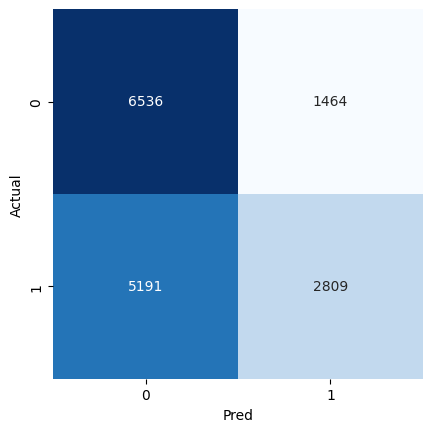

In [155]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
 
y_predicted = model.predict_proba(X_test)[:,1] > 0.5
mat = confusion_matrix(y_test, y_predicted)
labels = ['0', '1']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Pred')
plt.ylabel('Actual')

## Model's feature imporant scores

<AxesSubplot: >

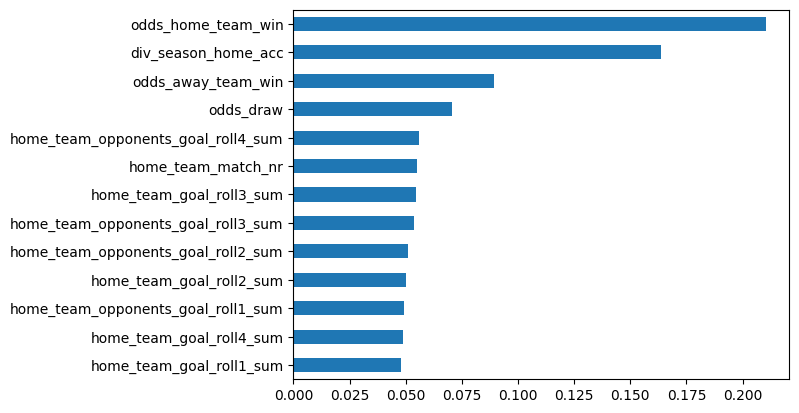

In [36]:
feat_importances = pd.Series(model.feature_importances_, index = train_feature).sort_values(ascending = True)
feat_importances.plot(kind = 'barh')

In [14]:
X = train_df

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


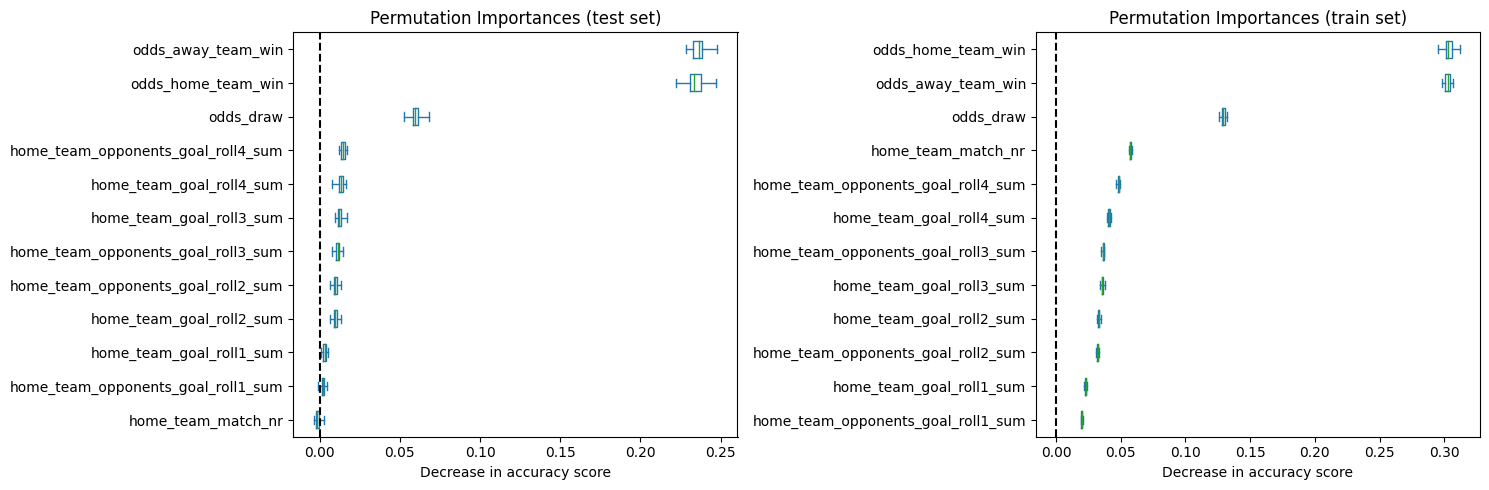

In [15]:
#calculate permutation importance for test data 
result_test = permutation_importance(
    model, X_val, y_val, n_repeats=20, random_state=42, n_jobs=2
)

sorted_importances_idx_test = result_test.importances_mean.argsort()
importances_test = pd.DataFrame(
    result_test.importances[sorted_importances_idx_test].T,
    columns=X.columns[sorted_importances_idx_test],
)

#calculate permutation importance for training data 
result_train = permutation_importance(
    model, X_train, y_train, n_repeats=20, random_state=42, n_jobs=2
)

sorted_importances_idx_train = result_train.importances_mean.argsort()
importances_train = pd.DataFrame(
    result_train.importances[sorted_importances_idx_train].T,
    columns=X.columns[sorted_importances_idx_train],
)

f, axs = plt.subplots(1,2,figsize=(15,5))

importances_test.plot.box(vert=False, whis=10, ax = axs[0])
axs[0].set_title("Permutation Importances (test set)")
axs[0].axvline(x=0, color="k", linestyle="--")
axs[0].set_xlabel("Decrease in accuracy score")
axs[0].figure.tight_layout()

importances_train.plot.box(vert=False, whis=10, ax = axs[1])
axs[1].set_title("Permutation Importances (train set)")
axs[1].axvline(x=0, color="k", linestyle="--")
axs[1].set_xlabel("Decrease in accuracy score")
axs[1].figure.tight_layout()